In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import h5py
from PIL import Image
from scipy import ndimage
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 1


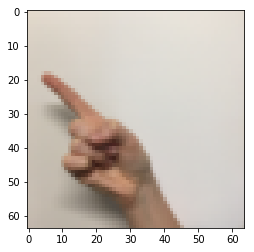

In [12]:
index = 7
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [18]:
X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print("Number of training examples: " + str(X_train.shape[0]))
print("Number of test examples: " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))

Number of training examples: 1080
Number of test examples: 120
X_train shape: (1080, 64, 64, 3)
X_test shape: (120, 64, 64, 3)
Y_train shape: (1080, 6)
Y_test shape: (120, 6)


In [31]:
def model(X_train, Y_train, X_test, Y_test, num_epochs=100, learning_rate=0.009, minibatch_size=64, print_cost=True):
    ops.reset_default_graph()
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    #Create placeholders for input data
    X,Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    #Initialize parameters
    parameters = initialize_parameters()
    
    #Forward propagation
    """
    We just need to build a way for tf to get Z for the third layer, rest everything is taken care of by tf
    """
    Z3 = forward_propagation(X, parameters)
    
    #Compute Cost
    cost = compute_cost(Z3, Y)
    
    #Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Initialize all variables globally
    init = tf.global_variables_initializer()
    
    #Start the session to compute tensor graph
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m/minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            
            #Print the cost every epoch
            if print_cost == True and epoch%5==0:
                print("Cost after epoch %i: %f" %(epoch, minibatch_cost))
            if print_cost == True and epoch%1==0:
                costs.append(minibatch_cost)
            
        #plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.922682
Cost after epoch 5: 1.580967
Cost after epoch 10: 1.314288
Cost after epoch 15: 1.182376
Cost after epoch 20: 1.089592
Cost after epoch 25: 1.026097
Cost after epoch 30: 1.002660
Cost after epoch 35: 0.958570
Cost after epoch 40: 0.947263
Cost after epoch 45: 0.927360
Cost after epoch 50: 0.908705
Cost after epoch 55: 0.898497
Cost after epoch 60: 0.894465
Cost after epoch 65: 0.871978
Cost after epoch 70: 0.857373
Cost after epoch 75: 0.873191
Cost after epoch 80: 0.857813
Cost after epoch 85: 0.859705
Cost after epoch 90: 0.833502
Cost after epoch 95: 0.842581


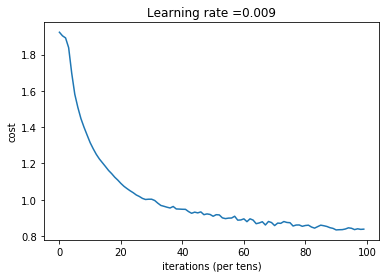

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.703704
Test Accuracy: 0.625


In [32]:
_,_,parameters = model(X_train, Y_train, X_test, Y_test)

# Supporting Functions

In [19]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

X,Y = create_placeholders(64,64,3,6)
print("X= " + str(X))
print("Y= " + str(Y))

X= Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y= Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [23]:
def initialize_parameters():
    """
    We just have to initialize the weights for the conv layers. The weights for fully connected layers are initilized
    by tf automatically.
    
    So here we want the filters for the first layer to be a 4x4 with 8 filters and second layer is 2x2 with 16
    layers
    
    Hence W1 is of shape [4, 4, 3, 8] and W2 is [2, 2, 8, 16]
    
    Also we don't have to worry about the bias when working with tensor flow. Those are initialized automatically
    """
    
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {
        "W1": W1,
        "W2": W2
    }
    
    return parameters

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1, 1, 1]))
    print("W2 = " + str(parameters["W2"].eval()[1, 1, 1]))

W1 = [-0.0752826   0.08046506 -0.18115364  0.01793462 -0.11417466 -0.15131985
 -0.1336818  -0.06460937]
W2 = [ 0.18771225  0.02089775  0.00491112 -0.12298661 -0.04200333  0.13979024
  0.05375856 -0.10530782 -0.15856427  0.19796973  0.04295498 -0.0471608
  0.01342118  0.21189791  0.1855194  -0.13519925]


In [25]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    """
    We have to do this
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    In FULLYCONNECTED part, we just have to take the flatten vector to Z and not apply the activation function 
    just yet. We need Z to compute cost where we will define the activation frunction for the final layer 
    

    In TensorFlow, there are built-in functions that carry out the convolution steps for you.

    tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'): given an input X and a group of filters  W1,
    this function convolves  W1's filters on X. The third input ([1,f,f,1]) represents the strides for each 
    dimension of the input (m, n_H_prev, n_W_prev, n_C_prev).

    tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'): given an input A, this function 
    uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. 

    tf.nn.relu(Z1): computes the elementwise ReLU of Z1 (which can be any shape).

    tf.contrib.layers.flatten(P): given an input P, this function flattens each example into a 1D vector it while 
    maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k].

    tf.contrib.layers.fully_connected(F, num_outputs): given a the flattened input F, it returns the output 
    computed using a fully connected layer.
    
    """
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    #how do you decide ksize is not really known. A1 is 64x64 since padding is SAME.
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    
    #Flatten before fully connected
    P2 = tf.contrib.layers.flatten(P2)
    
    #Fully connected upto activation step
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs=6, activation_fn=None)
    
    return Z3

In [26]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost